# Quiz Extra

## Imports

In [2]:
import numpy as np
import pickle
from sklearn.datasets import fetch_openml
import os.path
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Definición de Framework

### Funciones

In [3]:
"""
Definición de funciones de activación y sus derivadas
"""
def tanh(x):
    return np.tanh(x)

def tanh_grad(x):
    return 1.0 - np.tanh(x)**2

def linear(x):
    return x

def linear_grad(x):
    return np.ones_like(x)

def mse_loss(y_pred, y_true):
    return np.mean((y_pred - y_true)**2)

def mse_grad(y_pred, y_true):
    return 2 * (y_pred - y_true) / y_pred.shape[0]

### Base

In [4]:
class base():
    def __init__(self, input_size, output_size, use_xavier=True) -> None:
        self.input_size = input_size
        self.output_size = output_size
        if use_xavier:
            self._xavier_initialization()
        else:
            self._initialization_uniform()
        self.o = np.zeros(output_size)
        self.x = None

    def _initialization_uniform(self):
        self.W = np.random.randn(self.input_size, self.output_size)
        self.b = np.random.randn(self.output_size)
        
    def _xavier_initialization(self):
        self.W = np.random.randn(self.input_size, self.output_size) / np.sqrt(self.input_size)
        self.b = np.random.randn(self.output_size)
    
    def forward(self, x):
        pass
    
    def backward(self, prev):
        pass

    def update(self, lr):
        self.W -= lr * np.dot(self.x.T, self.grads)
        self.b -= lr * np.mean(self.grads, axis=0)

### Regression Layer

In [5]:
class regression_layer(base):
    def __init__(self, input_size, output_size) -> None:
        super().__init__(input_size, output_size)
        self.grads = np.zeros((output_size, input_size))

    def forward(self, x):
        self.x = x
        self.output = np.dot(x, self.W) + self.b
        return self.output
    
    def backward(self, y):
        self.grads = mse_grad(self.output, y)
        
    def loss(self, y):
        return mse_loss(self.output, y)

### Dense Layer

In [6]:
class dense(base):
    def __init__(self, input_size, output_size, func_activation, func_activation_grad):
        super().__init__(input_size, output_size)
        self.grads = np.zeros((output_size, input_size))
        self.func_activation = func_activation
        self.func_activation_grad = func_activation_grad
        
    def forward(self, x):
        self.x = x
        self.linear = np.dot(x, self.W) + self.b
        self.o = self.func_activation(self.linear)
        return self.o 

    def backward(self, prev):
        self.grads = self.func_activation_grad(self.linear) * np.dot(prev.grads, prev.W.T)


## Definición de Modelo

In [7]:
class model():
    def __init__(self, input_size, output_size, hidden_shapes, func_acti, func_acti_grad):
        assert(len(hidden_shapes) > 0), "Debe tener al menos 1 capa oculta"
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_shapes = hidden_shapes
        self.hidden_amount = len(self.hidden_shapes)
        self.hidden_layers = []
        self._populate_layers(func_acti, func_acti_grad)

    def _populate_layers(self, func_acti, func_acti_grad):
        input_size = self.input_size
        for i in range(0, self.hidden_amount):
            new_dense_layer = dense(input_size, self.hidden_shapes[i], func_acti, func_acti_grad)
            self.hidden_layers.append(new_dense_layer)
            input_size = self.hidden_shapes[i]

        self.regression_layer = regression_layer(input_size, self.output_size)

    def forward(self, x, y):
        data = x
        for i in range(0, self.hidden_amount):
            data = self.hidden_layers[i].forward(data)
        
        self.o = self.regression_layer.forward(data)
        loss = self.regression_layer.loss(y)
        
        return self.o, loss
    
    def predict(self, x):
        data = x
        for i in range(0, self.hidden_amount):
            data = self.hidden_layers[i].forward(data)
        
        return self.regression_layer.forward(data)
    
    def backward(self, y, o):
        self.regression_layer.backward(y)
        prev = self.regression_layer

        for i in reversed(range(self.hidden_amount)):
            self.hidden_layers[i].backward(prev)
            prev = self.hidden_layers[i]

    def update(self, lr):
        for i in range(self.hidden_amount):
            self.hidden_layers[i].update(lr)
        self.regression_layer.update(lr)


## Dataset

In [8]:
# Generar dataset sintético para regresión
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y.reshape(-1, 1)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

class dataset():
    def __init__(self, x, y, batch_size):
        self.compl_x = x
        self.compl_y = y
        self.batch_size = batch_size
        self.reset()
        self.size = len(self.compl_y)

    def next(self):
        if self.left_items < self.batch_size:
            x = self.x[self.current:]
            y = self.y[self.current:]
            self.current += len(x)
            self.left_items = 0
            return x, y
        else:
            x = self.x[self.current:self.current+self.batch_size]
            y = self.y[self.current:self.current+self.batch_size]
            self.current += self.batch_size
            self.left_items -= self.batch_size
            return x, y

    def iter_done(self):
        return self.left_items == 0

    def reset(self):
        indices = np.random.permutation(len(self.compl_x))
        self.x = self.compl_x[indices]
        self.y = self.compl_y[indices]
        self.current = 0
        self.left_items = len(self.compl_y)

class historian():
    def __init__(self):
        self.iter = []
        self.loss = []

    def add(self, iter, loss):
        self.iter.append(iter)
        self.loss.append(loss)


## Hyperparameters

In [9]:
# Configuración y entrenamiento
input_size = X_train.shape[1]
output_size = 1
hidden_shapes = [64, 32]
batch_size = 32
epochs = 50
lr = 0.001

## Ejecución

In [10]:
class nnplotter():
    @classmethod
    def view(cls, val_history, train_history):
        plt.figure(figsize=(10, 6))
        plt.plot(val_history.iter, val_history.loss, 'b-', label="Validation Loss", alpha=0.7)
        plt.plot(train_history.iter, train_history.loss, 'r-', label="Training Loss", alpha=0.7)
        plt.ylabel("Mean Squared Error")
        plt.xlabel("Iteration")
        plt.title("Training and Validation Loss Over Time")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        plt.yscale('log')  # Usar escala logarítmica para mejor visualización
        plt.tight_layout()
        plt.show()

In [13]:
def train(nn, epochs, batch_size, lr, X_train, y_train, X_val, y_val):
    train_dataset = dataset(X_train, y_train, batch_size)
    val_dataset = dataset(X_val, y_val, batch_size)
    
    train_hist = historian()
    val_hist = historian()
    
    iteration = 0
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(epochs):
        train_loss = 0
        train_count = 0
        
        while not train_dataset.iter_done():
            x_batch, y_batch = train_dataset.next()
            predictions, batch_loss = nn.forward(x_batch, y_batch)
            nn.backward(y_batch, predictions)
            nn.update(lr)
            
            train_loss += np.mean(batch_loss)
            train_count += 1
            
            if iteration % 50 == 0:
                # Calcular pérdida de validación
                val_loss = 0
                val_count = 0
                val_dataset.reset()
                
                while not val_dataset.iter_done():
                    x_val, y_val_batch = val_dataset.next()
                    val_pred, val_batch_loss = nn.forward(x_val, y_val_batch)
                    val_loss += np.mean(val_batch_loss)
                    val_count += 1
                
                avg_val_loss = val_loss / val_count
                avg_train_loss = train_loss / train_count
                
                train_hist.add(iteration, avg_train_loss)
                val_hist.add(iteration, avg_val_loss)
                
                print(f"Epoch {epoch+1}, Iteration {iteration}")
                print(f"Training Loss: {avg_train_loss:.6f}")
                print(f"Validation Loss: {avg_val_loss:.6f}\n")
                
                # Early stopping
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print("Early stopping triggered!")
                        return train_hist, val_hist
            
            iteration += 1
        
        train_dataset.reset()
    
    return train_hist, val_hist

Epoch 1, Iteration 0
Training Loss: 38088.629145
Validation Loss: 44898.092787

Epoch 3, Iteration 50
Training Loss: 7895.860842
Validation Loss: 9012.037998

Epoch 6, Iteration 100
Training Loss: 3593.505005
Validation Loss: 5253.881367

Epoch 8, Iteration 150
Training Loss: 1802.498088
Validation Loss: 2788.245248

Epoch 11, Iteration 200
Training Loss: 631.782837
Validation Loss: 2029.669215

Epoch 13, Iteration 250
Training Loss: 1229.972050
Validation Loss: 1793.851416

Epoch 16, Iteration 300
Training Loss: 766.365970
Validation Loss: 1337.824571

Epoch 18, Iteration 350
Training Loss: 699.046464
Validation Loss: 1250.319698

Epoch 21, Iteration 400
Training Loss: 495.111347
Validation Loss: 934.465413

Epoch 23, Iteration 450
Training Loss: 397.059717
Validation Loss: 873.661265

Epoch 26, Iteration 500
Training Loss: 521.813653
Validation Loss: 1246.918243

Epoch 28, Iteration 550
Training Loss: 1792.752633
Validation Loss: 3188.147977

Epoch 31, Iteration 600
Training Loss: 14

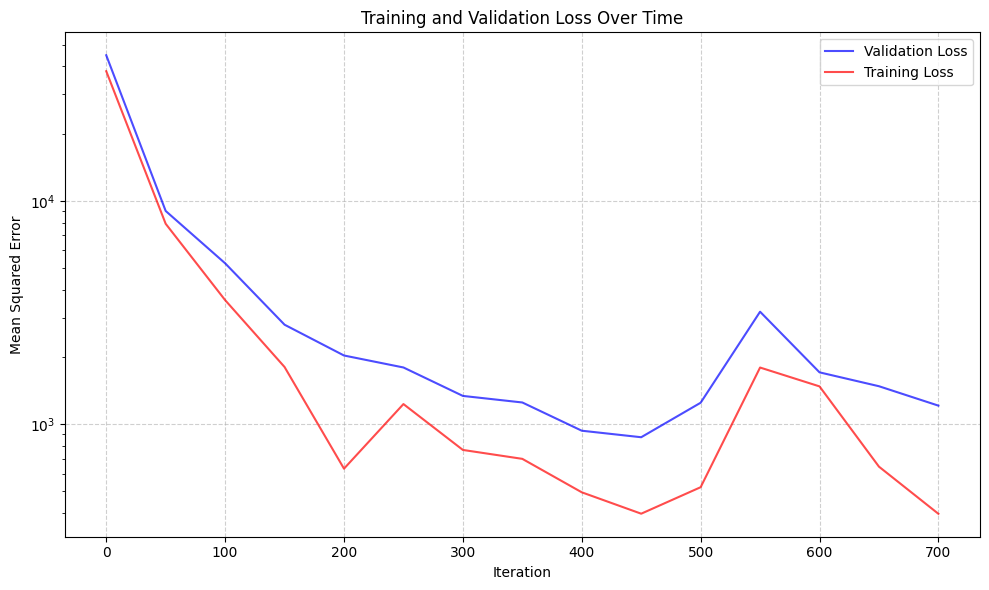


Test Loss: 1235.079215


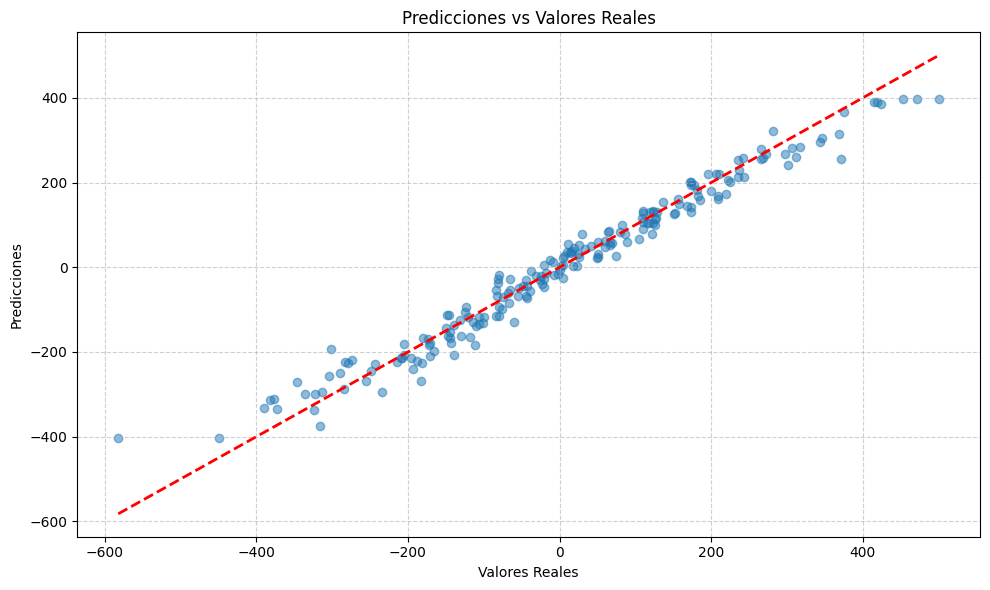

In [14]:
# Crear y entrenar el modelo
nn = model(input_size, output_size, hidden_shapes, tanh, tanh_grad)
train_hist, val_hist = train(nn, epochs, batch_size, lr, X_train, y_train, X_val, y_val)

# Visualizar resultados
nnplotter.view(val_hist, train_hist)

# Evaluar en conjunto de prueba
test_predictions = nn.predict(X_test)
test_loss = mse_loss(test_predictions, y_test)
print(f"\nTest Loss: {test_loss:.6f}")

# Visualizar predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()